# B-Tree Code

In this lab, we have supplied the code for B-Tree and a brief description of how to implement the various operations.  The exposition below follows this very nice survey:
<div class="alert alert-block alert-info">
    Douglas Comer, <a href="https://dl.acm.org/doi/pdf/10.1145/356770.356776"> Ubiquitous B-Tree. </a> ACM Comput. Surv. 11, 2 (June 1979), 121–137. 
</div>
Please take a look at the survey -- it does an excellent job of explaining the techniques at a high level with examples.

<div class="alert alert-block alert-warning">
<b>Warning:</b> This is an "advanced" data structure. The implementation is going to be longer than usual. We suggest however that you examine the notes in detail. The upcoming problem set will require it.
</div> 

We have built in three stages: 
   - `BTreeBaseNode` : implements all the necessary fields that one needs in a BTree node and some important utility functions.
   - `BTreeWithNodeInsert` : implements the function to insert a key into the BTree.
   - `BTreeNode`: adds the function to delete a key on top of `BTreeWithInsert`

Each class inherits from the previous one. 

### Structure of a BTree Node

Each BTree node will have the following fields:
  - `d`: the value of the parameter $d$ for the B-Tree. This should be the same for all the nodes in the tree.
  - `keys`: a list of keys that are sorted in ascending order. The length of `keys` must be between 0 and $2d$ for the root node and between $d$ and $2d$ for internal nodes.
  - `pointers`: list of pointers to child nodes. 
      - If the node is a leaf, the length of `pointers` will be $0$.
      - If the node is not a leaf, the length of `pointers` will be one more than the length of `keys`.
  - `is_root`: Boolean indicating if the node is a root.
  - `parent`: for a root node this will be `None`, otherwise, it will be a tuple of the form `(parent_node, parent_idx)`, wherein 
    - `parent_node` is a pointer to the nodes parent node.
    - `parent_idx` is the index of the current node in the list `parent_node.pointers`.
    - In other words, `parent_node.pointers[parent_idx] == self`.
  - For a key `keys[i]` its left child is at `pointers[i]` which will point to a node whose keys are $ < \text{keys}[i]$; and its right child is at `pointers[i+1]` which will point to a node whose keys are $> \text{keys}[i]$ (but less than $\text{keys}[i+1]$ if that exists).
  

## Implementing Find

We have an implementation of the `find` function for B-Tree which uses the `find_key_internal` function. The 
`find_key_internal` method seeks to find the node that contains a key and the index into the nodes, or return `None` if the key is not part of the tree.

  - Starting from the root, it searches for the key at the current node.
    - If the key is found, it returns immediately.
  - Otherwise, it fetches the child node whose subtree will contain the key if it is in the tree, and recursively calls `find_key_internal` on the child node.
  


In [20]:
class BTreeNodeBase(object):
    def __init__(self, keys = [], ptrs = [], is_root=False, d = 10):
        # each internal node must contain at least d keys and at most 2d  keys
        # The root which may contain between 0 keys (if entire tree is empty) and 2d keys
        self.keys = list(keys) # the keys
        self.d = d # the value of d
        self.pointers = list(ptrs)  # the pointers 
        self.is_root = is_root
        self.parent = None # either None or a tuple (parent_node, idx) such that parent_node.pointers[idx] = self
        
    def is_leaf(self):
        """returns True if the node is a leaf or else returns False"""
        return len(self.pointers) == 0
    
    def set_parent(self, parent_node, idx):
        assert parent_node != None
        assert 0 <= idx and idx < len(parent_node.pointers)
        assert parent_node.pointers[idx] == self
        self.parent = (parent_node, idx)
    
    def find_key_internal(self, k):
        """ find_key_internal for a key k returns reference to node and the index into keys array if found.
            Otherwise, returns None
        """     
        n = len(self.keys)
        if n == 0: # empty node return False 
            return None
        # find first index i such that self.keys[i] >= k
        i = 0
        while i < n and self.keys[i] < k:
            i = i + 1
        if i < n and self.keys[i] == k:
            return (self, i) # we are done: found the key
        else: 
            if  self.is_leaf(): # if we are at a leaf, then key not found
                return None
            else: # otherwise, we recursively search in the appropriate child node
                return self.pointers[i].find_key_internal(k)
            
    def find_key(self, k):
        """find_key function to be called  at the root node"""
        assert self.is_root
        res = self.find_key_internal(k) # call the find_key_internal method
        return True if res != None else False 
    
    def find_successor(self, idx):
        """find_successor : traverse the node to the right of idx 
            and then keep traversing left children until we get to a leaf"""
        assert idx >= 0 and idx < len(self.keys) # assert that the index is a proper index
        assert not self.is_leaf() # do not call this function on a leaf
        child = self.pointers[idx+1] # get the right child 
        while not child.is_leaf():
            child = child.pointers[0] # go left 
        assert child.is_leaf() # we have gotten to the leftmost leaf
        return (child.keys[0], child)
    
    def __str__(self):
        return str(self.keys)
    
    def make_networkx_graph(self, G, node_id, parent_id, label_dict):
        """This is for visualiztion. Add the details of the node including its outgoing 
           edges to the graph G so that we can draw out the tree."""
        node_label = str(self.keys)
        if self.parent != None:
            node_label =  "C"+str(self.parent[1]) + ": " + node_label
        else:
            node_label = "R: "+ node_label
        G.add_node(node_id, label=node_label)
        label_dict[node_id] = node_label
        if parent_id >= 0:
            G.add_edge(parent_id, node_id)
        n = len(self.pointers)
        new_id = node_id+1
        for i in range(n):
            new_id = self.pointers[i].make_networkx_graph(G, new_id, node_id, label_dict)
        return new_id + 1
    
    def rep_ok(self):
        """Check if the BTree respects  properties."""
        n = len(self.keys)
        p = len(self.pointers)
        d = self.d
        # node is a leaf with no pointers or it must have one more pointer than the number of keys
        assert p == 0 or p == n + 1, f'Node has {n} keys but {p} pointers'
        # are the keys in ascending order 
        for i in range(1, n):
            assert self.keys[i] > self.keys[i-1], f'Keys {keys[i-1]} and {keys[i]} fail to be in ascending order' 
        if self.is_root:
            assert self.parent == None # root has no parent
            assert 0 <= n and n <= 2 * d  # number of keys for root must be within [0, 2d]
            self.check_height_properties() # check that the length of all paths from root to leaf are the same
        else:
            assert self.parent != None # non root must have a parent
            assert d <= n and n <= 2 * d  # number of keys must be within [d, 2d]
        if p >= 1:
            for (j, child_node) in enumerate(self.pointers): # for each child node
                assert child_node.parent == (self, j) # is the parent pointer of the child node correct?
                assert child_node.d == self.d
                assert not child_node.is_root
                child_node.rep_ok() # check if the child node itself respect properties recursively
    
    def check_height_properties(self):
        """Check that the height of all child nodes are the same and return height of self"""
        if self.is_leaf():
            return 0
        else:
            depths= [child.check_height_properties() for child in self.pointers]
            d0 = depths[0]
            assert all(di == d0 for di in depths), f'Node with keys {self.keys} has mismatched depths'
            return 1 + d0
        
    def create_new_instance(self, keys, ptrs, is_root, d):
        """We need this to construct a new instance because we chose to split the implementation across three different classes"""
        return BTreeNodeBase(keys, ptrs, is_root, d)

## Inserting a Key into the BTree

We will implement the `insert` function that insert a key `new_key` into the tree. The key logic is 
implemented in the `insert_helper` function. 

<div class="alert alert-block" style="border-color:black white black white">
  We will assume that the key to be inserted is not part of the tree though this is also handled in our implementation. Note that in a search tree, a key can appear at most once in the tree.
</div>


The `insert_helper` function has two phases:
  - First,  it descends from the root to the leaf as if trying to search for the `new_key` that we wish to insert.
  - Next, it inserts the `new_key` at the leaf first and ascends back up to the root to try and fix nodes that may have become full as a result of the insertion.
  
  
### (A) Search for Leaf that will contain the new key

The first phase goes down from the root to a leaf that will contain the new key to be inserted.
  - At each non-leaf node, we search for an index `i` such that `node.keys[i] > new_key`. If no such `i` is found, the `new_key` will go into the rightmost branch of the tree.
  - We recursively call the `insert_helper` function for the appropriate child.
  
### (B) Insert new key at the leaf

We insert the new key at the leaf. This process is implemented in the `insert_key_into_list` function. The idea is to insert the `new_key` at the very end and keep swapping consecutive keys until the list is back to being sorted.

  - If as a result, the node continues to have $\leq 2d$, we are done.
  - If, however, the node becomes full: i.e, it now has $2d+1$ keys, we need to fix it.

To fix a node that has become full, we split the node into three parts:
  - The median key `keys[d]`
  - The list of keys to the left of median
  - The list of keys to the right of median.

To this end, we will create two nodes (we actually reuse the current node as one of the two) one containing the keys to the left and the other containing the keys to the right.  This is implemented in the function `split_node_into_two`.

As a result, we need to insert the median key into the parent of the current node with the two newly created nodes as its left and right children.

### (C) Inserting key back up into the parent

To insert a key back into the parent, we use the return values of the `insert_helper` function. When `insert_helper` is called by a parent for its $i^{th}$ child node, its return value can be `None` indicating that the insertionis done or a triple `(median_key, left, right)` that requires us to insert `median_key` into the current node with a `left` and `right` child for it. In fact, we know that `median_key` will be inserted into position `i` and the remaining keys will move one place to the right. Similarly, the `left` node will become the new child number `i` and `right` node will be inserted as child number `i+1`. The other children will be moved one place to the right.

To accomodate this, we have the function `insert_key_and_ptr`.
  
### (D) New Root

In some cases, the insertion will create a new root for the B-Tree. This needs to be handled by the `insert` function returning the pointer to the new root node if the root node changes or just the original root node, if not.

In [21]:
class BTreeNodeWithInsert(BTreeNodeBase):
    
    def __init__(self, keys = [], ptrs = [], is_root=False, d = 10):
        super().__init__(keys, ptrs, is_root, d)
        
    def create_new_instance(self, keys, ptrs, is_root, d):
        """We need this to construct a new instance because we chose to split the implementation across three different classes"""
        return BTreeNodeWithInsert(keys, ptrs, is_root, d)
    
        
    def insert(self, new_key):
        """Insert a key new_key into the tree. 
           Call this only when self is the root node"""
        assert self.is_root
        res = self.insert_helper(new_key) # the helper function has the logic for insertion
        if res != None: 
            (mid_key, n1, n2) = res # if the helper function returns a triple mid_key and two new nodes
            self.is_root = False  # we need to create a new root
            new_root = self.create_new_instance( [mid_key], [n1, n2], True, self.d) # create new root with a single key and two children
            n1.set_parent(new_root, 0) # set the parent pointers for n1, n2
            n2.set_parent(new_root, 1)
            return new_root  # return the new_root
        else:
            return self # Otherwise, the root node is unchanged
    
    def insert_helper(self, new_key, debug=True):
        """ This is a helper function for inserting a new key new_key into a node. 
        It returns either None which means that there was space for the key 
        or a triple (mid_key, n1, n2) to be inserted up into the parent node."""
        # if the node is a leaf
        if self.is_leaf(): 
            self.insert_key_into_list(new_key) # insert the key into the list
            n = len(self.keys)  # count the number of keys
            if n <= 2* self.d:  # node size is acceptable
                return None       # we are done, return None
            else:
                # node is full, we need to split 
                assert n == 2 * self.d + 1 # Node just became full as a result of this new insertion
                (mid_key, n1, n2) = self.split_node_into_two() # split it into two nodes
                return (mid_key, n1,  n2) # return the two nodes and middle key
        else:
            # find first index i such that self.keys[i] >= k
            i = 0
            n = len(self.keys)
            while i < n and self.keys[i] < new_key:
                i = i + 1
            # We should not find a copy of the key 
            if  i < n and self.keys[i] == new_key:
                if debug:
                    print(f'Key {k} already exists') # this is bad but ignore for now
                return None           
            else:
                res = self.pointers[i].insert_helper(new_key) # insert into the child
                if res != None:
                    (mid_key, node_left, node_right) = res # unpack
                    # insert the new key coming up from the child into self along with the two pointers
                    self.insert_key_and_ptr(mid_key, node_left, node_right, i)
                    # did the node become full as a result of the insertion?
                    if len(self.keys) == 2 * self.d+1:
                        (mid_key, n1, n2) = self.split_node_into_two() # split myself into two
                        return (mid_key, n1, n2) # return the median key and two nodes back to my caller
                 
            
    def insert_key_into_list(self, new_key):
        """Insert new_key into the list for this node. Call this function only on leaf nodes"""
        assert self.is_leaf()
        n = len(self.keys)
        assert new_key not in self.keys, f'key {new_key} already exists {self.keys}'
        self.keys.append(new_key)
        i = n
        while i >= 1 and self.keys[i] < self.keys[i-1]:
            # swap
            (self.keys[i-1], self.keys[i]) =  (self.keys[i], self.keys[i-1])
            i = i-1
            
    def insert_key_and_ptr(self, mid_key, node_left, node_right, i):
        """Insert the new_key into the list at position i. 
           Make sure that its left child is 
           node_left and right child is node_right. """
        n = len(self.keys)
        assert i >= 0 and i <= n
        node_left.set_parent(self, i)
        #assert self.keys[i] > mid_key
        assert self.pointers[i] == node_left 
        (new_key, new_child) = (mid_key, node_right)
        for j in range(i, n):
            (self.keys[j], new_key) = (new_key, self.keys[j])
            (self.pointers[j+1], new_child) = (new_child, self.pointers[j+1])
            self.pointers[j+1].set_parent(self, j+1) # fix the parent pointer since the child node position changes
        self.keys.append(new_key)
        self.pointers.append(new_child)
        new_child.set_parent(self, n+1)
        
    def fix_parent_pointers_for_children(self):
        for (j, child_node) in enumerate(self.pointers):
            child_node.set_parent(self, j)
        
    def split_node_into_two(self):
        """Split a node into two along the median. Call only if the node is full"""
        assert len(self.keys) == 2 * self.d + 1 # node is full
        n = len(self.keys)
        d = self.d
        med_key = self.keys[d]
        new_keys = list(self.keys[d+1:]) # take all keys past position d + 1
        self.keys = list(self.keys[:d])
        if self.is_leaf():
            new_ptrs = []
        else:
            new_ptrs = list(self.pointers[d+1:])
            self.pointers = list(self.pointers[:d+1])
        new_node = self.create_new_instance(new_keys, new_ptrs, False, d) # create a new node 
        new_node.fix_parent_pointers_for_children() # make sure that for the new node, we fix the parent pointers for children to now point to the new node 
        return (med_key, self, new_node) ## return a triple of things to insert
        
    
       
    
        
   
        

In [22]:
%matplotlib inline
import networkx as nx 
from matplotlib import pyplot as plt 

def draw_btree_graph(n):
    G = nx.DiGraph()
    labels = {}
    n.make_networkx_graph(G, 0, -1, labels)
    pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # positions for all nodes
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    nx.draw(G, pos=pos, with_labels=True,  node_shape="s", font_size=8, labels=labels, node_color="none",  bbox=dict(facecolor="cyan", edgecolor='black'))
    # Set margins for the axes so that nodes aren't clipped
    ax = plt.gca()
    ax.margins(0.20)
    plt.axis("off")
    plt.show()


We will now illustrate insertion on some examples.

## Example 1

Consider the B-Tree below with $d=2$.

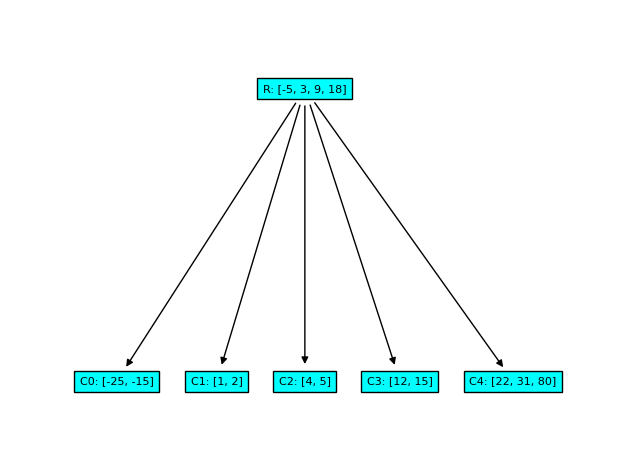

In [23]:
lst = [1, 5, 2, 4, 3, 9, 15, -5, 12, 18, 80, -25, 22, 31, -15]
b = BTreeNodeWithInsert(d=2,is_root=True)
for k in lst:
    b = b.insert(k)
b.rep_ok()
draw_btree_graph(b)

Suppose we wish to inset a new key `-2` into the tree.
  - First phase descends from root to the leaf C1 since $-5 \leq -2 \leq 3$.
  - The insertion happens at child `C1` which now has $[-2, 1, 2]$.
  - Since child `C1` is not full, no further actions are needed.

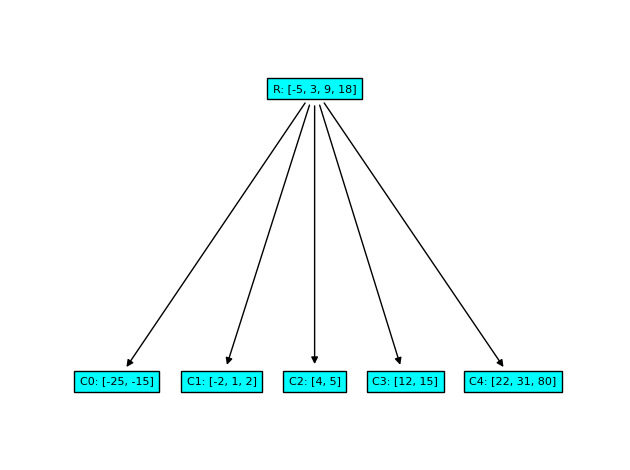

In [24]:
b = b.insert(-2)
b.rep_ok()
draw_btree_graph(b)

Suppose we would like to insert $71$, what would happen?

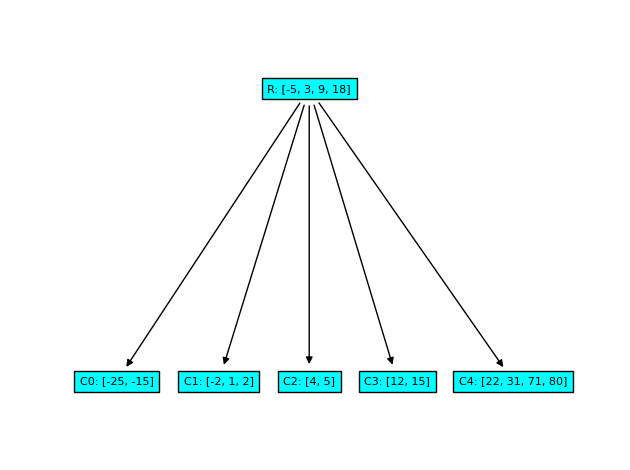

In [25]:
b = b.insert(71)
b.rep_ok()
draw_btree_graph(b)

Now let's try to insert `29`. This will cause an insertion at C4.
  - However, C4 is full after the insertion. We will split it into two nodes and insert the median key `31` back up into the root.
  - The root will now be full and split into two nodes with the median value $9$
  - We will finally have a new root with just one node with key $9$.

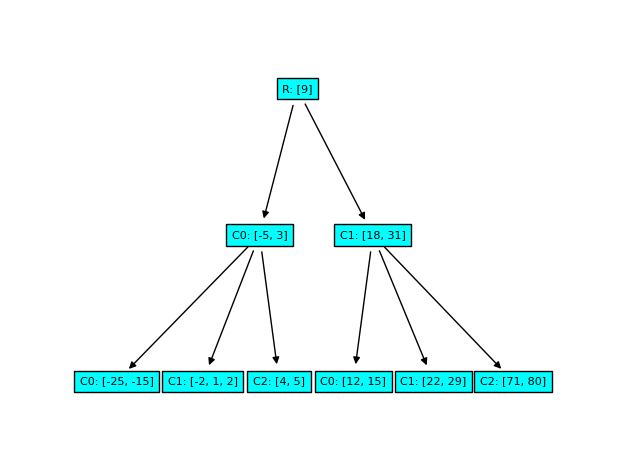

In [26]:
b = b.insert(29)
b.rep_ok()
draw_btree_graph(b)

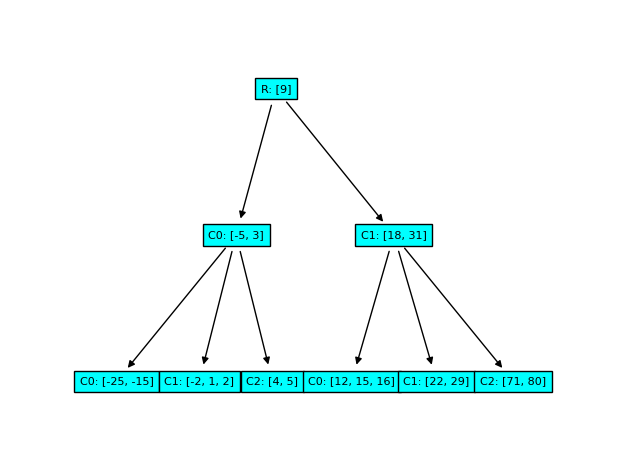

In [27]:
b.insert(16)
draw_btree_graph(b)

## Deleting a Key

We will finally create a BTreeNode class that extends the previously implemented insertion capabilities with the ability to delete a key from the tree.

### (A) Move deletion to a leaf node.

  - In order to delete a key, we first locate the key in the tree using the `find_internal` method that yields the node and the index into the node where the key may be found.
  - Next, if the node happens to be a non-leaf node, we will replace the key with its successor.
    - The successor to a node is found by taking its immediate right child and then moving to the leftmost leaf of that child.
    
For instance, consider the B-Tree below. Suppose we wish to delete the key `9` which is at the root (a non-leaf node), we find the successor (the next bigger key in the tree). It happens to be `12`. 
 - We first replace the key to be deleted by its successor and delete the successor but now from the leaf.

<img src="./deletion-fig.png" width="40%"></img>

Removing the key `12` from the leaf does not violate any constraints since the size of the leaf node is still $2$. 

This logic is implemented in the function `delete_key_helper` below.

### (B) Handle nodes that become "Under"-full

Suppose in the process above, the leaf size goes below the threshold $d$, we have to consider three cases:
   1. If the node has a right sibling which has $d+1$ or more keys, we can "borrow" a key from the right sibling (this will be explained below).
   2. Otherwise, if it has a  left sibling with $d+1$ or more keys, we borrow one key from the left sibling.
   3. Failing this, we merge the node with one of its "full" siblings, as explained below.
   
 This logic is implemented in the function `fix_underfull_node` below.



#### (B.1) Borrowing a Key from a Sibling Node

<img src="./borrow-from-sibling-fig.jpeg" width="40%"></img>

Figure above shows how to fix an under-full situation by borrowing a key from the right sibling. To do this: 
  - We move the key $k$ from the parent down to the node, and
  - Move the leftmost key $k'$ from the right sibling up to the parent.
  - Move the leftmost pointer from the right sibling node to become the rightmost pointer of the left sibling node.
  
  
This is implemented in the `borrow_from_right_sibling` function. As a result, the current node has $d$ keys and the sibling node has one less key than before. However, this immediately fixes the "underfull" node.

The situation for borrowing a key from the left sibling (if it exists) is symmetric: see `borrow_from_left_sibling` function below.

#### (B.2) Merging with a Sibling Node

If a sibling node has $d$ nodes as well then borrowing from it will not work since it will cause the sibling to go "underfull". We will merge two nodes into one.
  - The current node has $d-1$ keys.
  - The sibling has $d$ keys.
  - The key from the parent will move down.

Merging would yield a node with $2d$ keys. The figure below shows the process. However, it now requires us to delete the key from the parent which means that the parent can be underfull. We therefore need to then fix the parent unless the parent is a root.


<img src="./merge-with-sibling.jpeg" width="60%"> </img>

The function `merge_with_right_sibling` implements this process.

#### (B.3) Root can become empty

During this process, it is possible for the root to become empty.  This can only happen if
  - The root previously has one key in it and two children.
  - The two children of the root merge getting rid of the lone key in the root.

We will therefore need to handle this case by deleting the root and making the only remaining child the new root.


In [28]:
class BTreeNode(BTreeNodeWithInsert):
    
    def __init__(self, keys = [], ptrs = [], is_root=False, d = 10):
        super().__init__(keys, ptrs, is_root, d)
    
    def create_new_instance(self, keys, ptrs, is_root, d):
        """We need this to construct a new instance because we chose to split the implementation across three different classes"""
        return BTreeNode(keys, ptrs, is_root, d)
    
    def delete_key(self, key_to_delete):
        """This is the main routine to delete a key from the tree. It should be called at the root of the tree."""
        assert self.is_root # call this routine only at the root.
        result = self.delete_key_helper(key_to_delete) # call the helper method 
        if result == None:
            # root did not change 
            return self
        else:
            return result # result is the new root node for the tree 
        
    def delete_key_helper(self, key_to_delete, debug=True):
        """This is the main worker method for deleting a key from the tree."""
        # first find the node in the tree that has the key 
        res = self.find_key_internal(key_to_delete)
        if res == None: # the node was not found, nothing to delete
            print(f'Key {key_to_delete} does not exist in the tree') # warn the user 
            return None # bail!
        #Otherwise, we have found the key and now need to delete it.
        (node, idx) = res # unpack the result of find_key_internal to obtain the node and its index
        assert 0 <= idx and idx < len(node.keys) # idx is a proper index into the list of keys
        assert node.keys[idx] == key_to_delete # if this fails then our find routine is messed up!
        if not node.is_leaf(): # if it is not a leaf node
            (succ_key, successor_leaf_node) = node.find_successor(idx) # find successor key and node
            assert successor_leaf_node.is_leaf() 
            assert succ_key > node.keys[idx], f"Successor: {succ_key}, node key {node.keys[idx]}"
            assert succ_key == successor_leaf_node.keys[0]
            # replace the key with that of the successor
            if debug:
                print(f'Replacing {key_to_delete} with sucessor key {succ_key}')
            node.keys[idx] = succ_key # replace key with successor
            return successor_leaf_node.delete_key_leaf(0, debug) # delete the sucessor key starting from the leaf
        else: # deletion  is already at a leaf node
            return node.delete_key_leaf(idx, debug) # delete the key starting from the leaf
            
    def delete_key_leaf(self, idx, debug=True):
        """Delete a key that is at the leaf. self is a leaf node and idx is the index into the list of keys that needs to be deleted"""
        assert self.is_leaf() # do not call this method on a non-leaf method
        n = len(self.keys) 
        d = self.d
        assert 0 <= idx and idx < n
        for i in range(idx, n-1):
            self.keys[i] = self.keys[i+1] # move keys to the left, overwriting the key at position idx
        self.keys.pop() # remove the very last element 
        assert len(self.keys) == n-1 # I have deceased by one key
        if self.is_root or (n-1) >= d:  # check if I am underfull
            return None # not underfull -- nothing more to do
        else:
            # we have an underfull situation
            print(f'Delete causes node with keys {self.keys} to be under-full')
            return self.fix_underfull_node(debug) # fix the underfull node (see below)
    
    def fix_underfull_node(self, debug=True):
        """ Fix a node that has gone under-full as a result of deleting a key. """
        if self.is_root: # if we are aleady at the root, nothing to fix
            return None # nothing to fix
        if len(self.keys) >= self.d: # the node better be underfull
            return None # if not, bail out
        # node is actually underfull
        assert len(self.keys) == self.d -1  
        n = len(self.keys) 
        d = self.d
        assert self.parent != None # it is not the root, so it must have a parent node
        (parent_node, node_idx) = self.parent # fetch the parent node and the idx 
        n_parent = len(parent_node.keys) # how many keys does the parent have
        assert n_parent >= 1 # parent must always have one or more keys or else we have caused a property violation
        if node_idx <= n_parent-1 : 
            # I have a sibling to the right
            right_sibling_node = parent_node.pointers[node_idx+1]
            # Does the right sibling node have space
            n_right_sibling = len(right_sibling_node.keys)
            if n_right_sibling > d: 
                if debug:
                    print('Borrowing key from right sibling')
                self.borrow_from_right_sibling(right_sibling_node)
            else:
                if debug:
                    print('Merging with right sibling')
                # merge with right sibling -- note this will delete a key from the parent.
                self.merge_with_right_sibling(right_sibling_node)
                if parent_node.is_root and len(parent_node.keys) == 0:
                    # Merge caused an empty root 
                    if debug:
                        print('Root became empty: designating new root.')
                    self.parent = None
                    self.is_root = True
                    self.fix_parent_pointers_for_children()
                    return self
        else:
            assert node_idx >= 1
            # I have a sibling to the left
            left_sibling_node = parent_node.pointers[node_idx-1]
            # Does the left sibling node have space
            n_left_sibling = len(left_sibling_node.keys)
            if n_left_sibling > d: 
                if debug:
                    print('Borrowing from left sibling')
                self.borrow_from_left_sibling(left_sibling_node)
            else:
                if debug:
                    print('Merging with left sibling')
                # merge the left sibling with myself (since I am the right sibling of my left sibling)
                # note this will cause a key to be removed from the parent
                left_sibling_node.merge_with_right_sibling(self)
                if parent_node.is_root and len(parent_node.keys) == 0:
                    # Merge caused an empty root 
                    if debug:
                        print('Root became empty: designating new root.')
                    left_sibling_node.parent = None
                    left_sibling_node.is_root = True
                    left_sibling_node.fix_parent_pointers_for_children()
                    return left_sibling_node
                
        # if the parent is not a root and it has become underfull
        if not parent_node.is_root and len(parent_node.keys) < d: 
            # parent node is underfull, recursively fix the parent
            return parent_node.fix_underfull_node()
    
    def borrow_from_right_sibling(self, right_sibling_node):
        """Borrow a key from the right sibling node. Note that it should not become underfull as a result of the borrow"""
        assert self.parent != None
        (parent_node, parent_idx) = self.parent # get the parent
        assert right_sibling_node.parent != None
        assert right_sibling_node.parent[0] == parent_node, f"right sibling parent {right_sibling_node.parent[0]} my parent {parent_node}"
        assert right_sibling_node.parent[1] == parent_idx+1 # make sure that right_sibling node is indeed the right sibling node
        n_right_sibling = len(right_sibling_node.keys)
        assert n_right_sibling >= self.d + 1
        # Borrow key from right sibling
        # move key from parent down to self
        self.keys.append(parent_node.keys[parent_idx]) # add the parent key to myself
        parent_node.keys[parent_idx] = right_sibling_node.keys[0] # replace the parent key with leftmost key of right sibling
        right_sibling_node.keys.pop(0) # remove leftmost key from right sibling
        if not self.is_leaf(): # if it is not a leaf node, we have to fix the pointers as well
            assert not right_sibling_node.is_leaf() 
            # move pointer from right sibling down to self
            new_child_node = right_sibling_node.pointers[0] #get the leftmost pointer from right sibling
            self.pointers.append(new_child_node) # make it my rightmost pointer
            right_sibling_node.pointers.pop(0) # delete leftmost pointer from right sibling
            self.fix_parent_pointers_for_children() # fix the parent pointers to children from myself and right sibling
            right_sibling_node.fix_parent_pointers_for_children()
        return 
    
    def borrow_from_left_sibling(self, left_sibling_node):
        """Borrow a key from left sibling node. Similar structure as borrow_from_right_sibling function above."""
        assert self.parent != None
        (parent_node, parent_idx) = self.parent
        assert left_sibling_node.parent != None
        assert left_sibling_node.parent[0] == parent_node
        assert left_sibling_node.parent[1] == parent_idx-1
        n_sibling = len(left_sibling_node.keys)
        assert n_sibling >= self.d + 1
        self.keys.insert(0, parent_node.keys[parent_idx-1]) # insert the parent key as my leftmost key
        parent_node.keys[parent_idx-1] = left_sibling_node.keys[n_sibling-1] # replace the parent key with rightmost key of the left sibling
        left_sibling_node.keys.pop() # remove the rightmost key of left sibling
        if not self.is_leaf(): # if not a leaf, then pointers must be fixed
            assert not left_sibling_node.is_leaf() 
            self.pointers.insert(0, left_sibling_node.pointers[n_sibling]) # insert the rightmost pointer of left sibling as my leftmost pointer
            left_sibling_node.pointers.pop() # delete the rightmost pointer from left sibling
            self.fix_parent_pointers_for_children() # fix the parent pointers for my children and those of the left sibling
            left_sibling_node.fix_parent_pointers_for_children()
        return 
    

    
    def merge_with_right_sibling(self, right_sibling_node):
        """Merge with the right sibling to form a single node. Results in deletion of a key from the parent node."""
         # Merge with left sibling node to form a single node
        assert self.parent != None
        (parent_node, parent_idx) = self.parent
        assert right_sibling_node.parent != None
        assert right_sibling_node.parent[0] == parent_node
        assert right_sibling_node.parent[1] == parent_idx+1
        self.keys = self.keys + [parent_node.keys[parent_idx]] + right_sibling_node.keys # append the keys together, also get the parent node key as well
        assert len(self.keys) == 2 * self.d
        if not self.is_leaf(): # now fix the pointers
            assert not right_sibling_node.is_leaf()
            self.pointers = self.pointers + right_sibling_node.pointers # append the pointers
            assert len(self.pointers) == 2 * self.d + 1, f'Number of pointers = {len(self.pointers)}, d = {self.d}'
        parent_node.keys.pop(parent_idx) # remove the key from the parent
        parent_node.pointers.pop(parent_idx + 1) # remove the pointer from the parent to the right sibling node
        parent_node.fix_parent_pointers_for_children() # fix children pointers for the parent
        if not self.is_leaf():
            self.fix_parent_pointers_for_children() # fix my own children pointers
        return 
    
            
    
            
    
        

## Example

Consider the example below. 

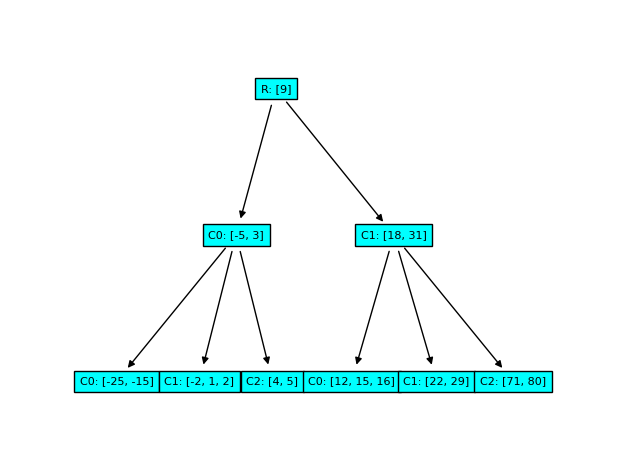

In [29]:
lst = [1, 5, 2, 4, 3, 9, 15, -5, 12, 18, 80, -25, 22, 31, -15, -2, 71, 29, 16]
b = BTreeNode(d=2,is_root=True)
for k in lst:
    b = b.insert(k)
b.rep_ok()
draw_btree_graph(b)

If we tried to delete the key `9`, it gets replaced by its successor `12`.

Replacing 9 with sucessor key 12


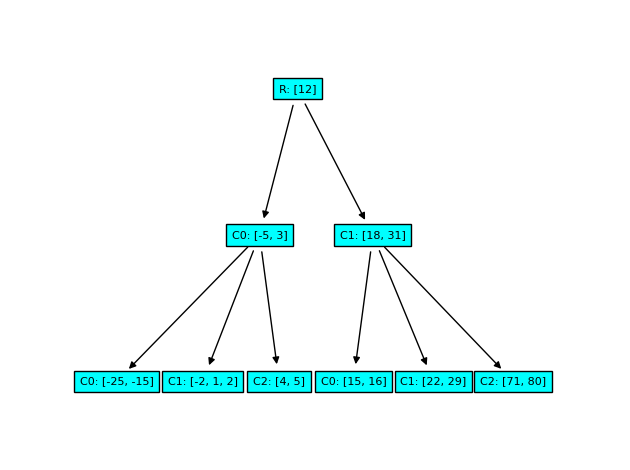

In [30]:
b = b.delete_key(9)
b.rep_ok()
draw_btree_graph(b)

Suppose we now try to delete the key $22$. It will cause the node $$R \rightarrow C1 \rightarrow C1$$ to become underfull. Since the node cannot borrow from its sibling, it needs to merge with a sibling. This in turn removes a key from $R \rightarrow C1$ and causes a merge between the previous root, $C0$ and $C1$. The root is now empty and needs to be replaced by a new root.

Delete causes node with keys [29] to be under-full
Merging with right sibling
Merging with left sibling
Root became empty: designating new root.


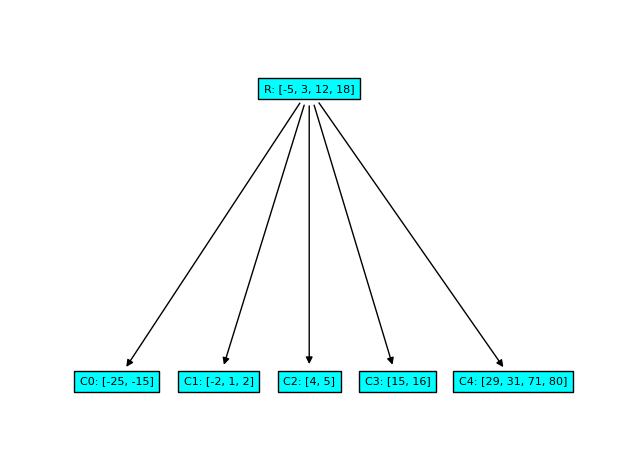

In [31]:
b = b.delete_key(22)
b.rep_ok()
draw_btree_graph(b)


Suppose we wish to delete the key $12$ at the root, it gets replaced by the key $15$ from $C3$. $C3$ becomes underful and to fix it, we borrow a key from $C4$.

Replacing 12 with sucessor key 15
Delete causes node with keys [16] to be under-full
Borrowing key from right sibling


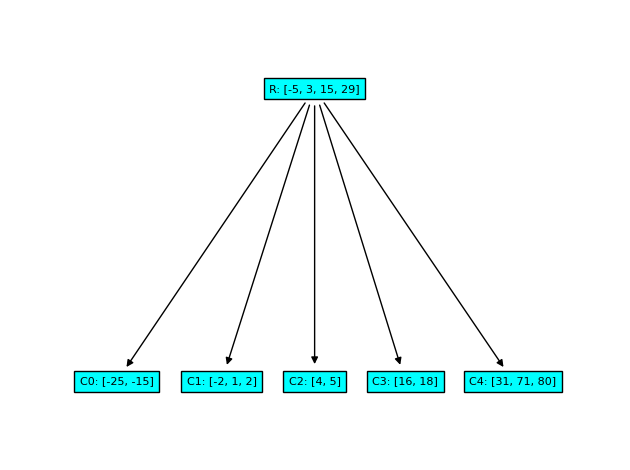

In [32]:
b = b.delete_key(12)
b.rep_ok()
draw_btree_graph(b)

[-17, -26, -20, -37, 16, -29, -6, -2, 33, 4, 0, -25, -30, 36, 11, -15, 15, 35, -27, -12, 13, -39, -38, 25, 12, 22, 9, 20, 24, 5, -33, 14, 2, 34, 26, -8, -21, 29, 8, 37, 31, -9, -18, -23, 30, 28, 1, -40, -14, 6, 3, 7, 18, -11, -22, 32, -36, 19, -34, 17, -28, 39, -10, 27, -16, -7, -35, 21, -1, -5, -13, -4, -19, -24, -3, -32, 23, 38, -31, 10]


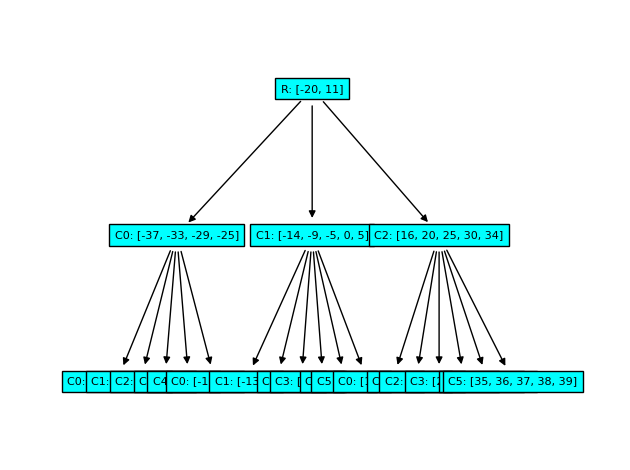

In [33]:
from random import shuffle
l = list(range(-40,40))
shuffle(l)
print(l)
b = BTreeNode(d=3,is_root=True)
for j in l:
    b = b.insert(j)
b.rep_ok()
draw_btree_graph(b)

[325, 324, 108, 77, -289, -132, 171, -179, -354, -73, -181, 62, 240, -205, 186, -8, 121, 272, -445, 378, -112, -81, -329, 442, 150, 445, 366, 481, -238, 433, -62, -46, 331, -324, 342, -257, 56, 93, -418, 416, 197, -307, -189, 158, 309, 360, -102, -385, -393, -410, 74, 397, 129, 1, -80, 496, 103, 463, -147, -101, -200, -330, 152, 146, -90, -364, -398, 192, -293, -171, 376, 370, 207, 313, 12, 203, 493, 461, -176, -195, -339, -400, -331, -456, 277, -234, -66, -27, 216, 140, 206, 79, -365, 382, 183, -146, -441, -202, 466, -484, -83, 384, 283, 221, 408, -22, -216, 64, 340, 135, -15, -355, -433, 68, -130, 439, -246, 100, -25, -435, -303, -151, 483, -5, -498, 315, -82, 393, -23, -211, -394, -468, -248, 141, 356, -4, 205, 118, 255, -316, -243, 44, -247, -120, 163, 76, 167, 444, -261, 323, 338, 302, 349, -413, 58, 265, -48, -70, -267, 199, 72, -376, 417, 32, 275, 20, -148, -310, 372, -390, 422, -63, 358, 22, -431, 484, -482, 291, 374, 13, 251, 470, 225, 290, -297, -421, -222, 200, -338, -42, -4

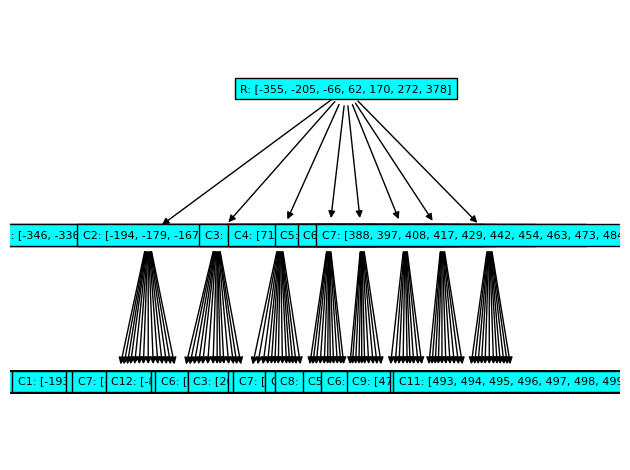

None

Replacing -420 with sucessor key -419
Replacing -419 with sucessor key -418
Replacing -418 with sucessor key -417
Replacing -417 with sucessor key -416
Replacing -416 with sucessor key -415
Replacing -415 with sucessor key -414
Delete causes node with keys [-413, -412, -411, -410, -409, -408] to be under-full
Borrowing key from right sibling
Replacing -414 with sucessor key -413
Delete causes node with keys [-412, -411, -410, -409, -408, -407] to be under-full
Borrowing key from right sibling
Replacing -413 with sucessor key -412
Delete causes node with keys [-411, -410, -409, -408, -407, -406] to be under-full
Borrowing key from right sibling
Replacing -412 with sucessor key -411
Delete causes node with keys [-410, -409, -408, -407, -406, -405] to be under-full
Merging with right sibling
Replacing -411 with sucessor key -410
Replacing -410 with sucessor key -409
Replacing -409 with sucessor key -408
Replacing -408 with sucessor key -407
Replacing -407 with sucessor key -406
Replacing 

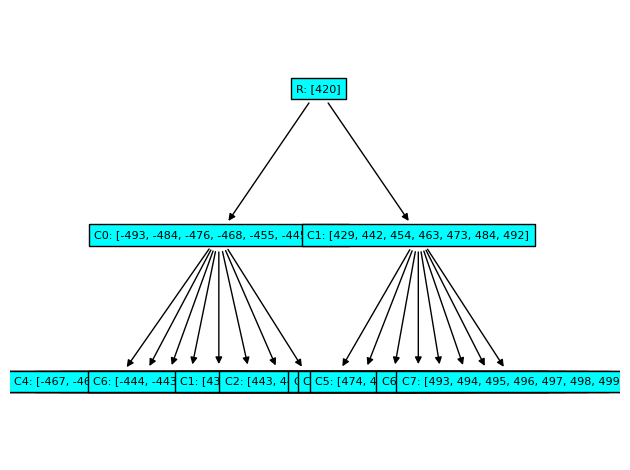

In [34]:
from random import shuffle
l = list(range(-500,500))
shuffle(l)
print(l)
b = BTreeNode(d=7,is_root=True)
for j in l:
    b = b.insert(j)
b.rep_ok()
display(draw_btree_graph(b))
for i in range(-425, 420):
    if b.find_key(i):
        b = b.delete_key(i)
b.rep_ok()
draw_btree_graph(b)